# LangGraph Calculator Agent

This notebook demonstrates how to build a **LangGraph agent** that can perform multiple calculations based on natural language user questions.

## What we'll build:
- A calculator agent with multiple mathematical tools (add, subtract, multiply, divide, power, square root, percentage)
- The agent can handle complex multi-step calculations
- It can understand natural language queries and break them down into calculation steps

## Requirements:
```bash
pip install langgraph langchain-openai langchain-core openai
```

In [9]:
# Install required packages (uncomment if needed)
# !pip install langgraph langchain-openai langchain-core openai

In [1]:
# Import all necessary libraries
from typing import TypedDict, Annotated, Sequence
import operator
import math

# LangGraph imports for building the agent graph
from langgraph.graph import StateGraph, END

# LangChain imports for messages and LLM
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

print("✓ All imports successful!")

✓ All imports successful!


## Step 1: Define Calculation Tools

We'll create individual tools for different mathematical operations. Each tool is decorated with `@tool` which makes it usable by the LLM agent.

The agent will automatically select and use these tools based on the user's question.

In [2]:
# Define mathematical operation tools
# Each function is decorated with @tool to make it available to the agent

@tool
def add(a: float, b: float) -> float:
    """Add two numbers together. Use this for addition operations."""
    return a + b


@tool
def subtract(a: float, b: float) -> float:
    """Subtract b from a. Use this for subtraction operations."""
    return a - b


@tool
def multiply(a: float, b: float) -> float:
    """Multiply two numbers together. Use this for multiplication operations."""
    return a * b


@tool
def divide(a: float, b: float) -> float:
    """Divide a by b. Use this for division operations."""
    if b == 0:
        raise ValueError("Cannot divide by zero")
    return a / b


@tool
def power(base: float, exponent: float) -> float:
    """Raise base to the power of exponent. Use this for exponentiation."""
    return base ** exponent


@tool
def square_root(x: float) -> float:
    """Calculate the square root of x. Use this for square root operations."""
    if x < 0:
        raise ValueError("Cannot calculate square root of negative number")
    return math.sqrt(x)


@tool
def percentage(value: float, percent: float) -> float:
    """Calculate percent% of value. For example, 20% of 100 = 20."""
    return (percent / 100) * value


# Create a list of all available tools
tools = [add, subtract, multiply, divide, power, square_root, percentage]

print(f"✓ Defined {len(tools)} calculation tools:")
for tool_func in tools:
    print(f"  - {tool_func.name}: {tool_func.description}")

✓ Defined 7 calculation tools:
  - add: Add two numbers together. Use this for addition operations.
  - subtract: Subtract b from a. Use this for subtraction operations.
  - multiply: Multiply two numbers together. Use this for multiplication operations.
  - divide: Divide a by b. Use this for division operations.
  - power: Raise base to the power of exponent. Use this for exponentiation.
  - square_root: Calculate the square root of x. Use this for square root operations.
  - percentage: Calculate percent% of value. For example, 20% of 100 = 20.


### 🔍 Discovering the Tool Call Structure

Let's inspect what GPT-4 returns when it wants to call a tool. This shows you how to discover the keys (`name`, `args`, `id`):

In [4]:
# test_message = [HumanMessage(content="What is 5 plus 3?")]
# response = llm_with_tools.invoke(test_message)
# print(response)

In [5]:
# type(response)

In [6]:
# # Let's see what GPT-4 returns when it wants to call a tool
# # We'll send a simple question and inspect the response

# print("=" * 70)
# print("RESPONSE TYPE:", type(response))
# print("=" * 70)

# # Check if it has tool_calls
# if hasattr(response, 'tool_calls'):
#     print("\n✅ Response has 'tool_calls' attribute")
#     print(f"Number of tool calls: {len(response.tool_calls)}")
    
#     # Inspect the first tool call
#     if response.tool_calls:
#         tool_call = response.tool_calls[0]
#         print(f"\n📦 Tool Call Type: {type(tool_call)}")
#         print(f"\n🔑 Available Keys: {tool_call.keys() if isinstance(tool_call, dict) else 'Not a dict'}")
#         print("\n" + "=" * 70)
#         print("FULL TOOL CALL STRUCTURE:")
#         print("=" * 70)
        
#         # Display the structure
#         import json
#         print(json.dumps(tool_call, indent=2))
        
#         print("\n" + "=" * 70)
#         print("ACCESSING INDIVIDUAL KEYS:")
#         print("=" * 70)
#         print(f"tool_call['name']:  {tool_call['name']}")
#         print(f"tool_call['args']:  {tool_call['args']}")
#         print(f"tool_call['id']:    {tool_call['id']}")
#         print(f"tool_call['type']:  {tool_call.get('type', 'N/A')}")
# else:
#     print("\n❌ No tool_calls in response")
#     print(f"Response content: {response.content}")

### 📚 Where These Keys Come From

**The answer: LangChain standardizes the format!**

1. **OpenAI's Raw Response**:
   ```json
   {
     "tool_calls": [
       {
         "id": "call_abc123",
         "type": "function",
         "function": {
           "name": "add",
           "arguments": "{\"a\":5,\"b\":3}"
         }
       }
     ]
   }
   ```

2. **LangChain Converts to Standard Format**:
   ```python
   {
     "name": "add",              # From function.name
     "args": {"a": 5, "b": 3},   # Parsed from function.arguments
     "id": "call_abc123",        # From id
     "type": "tool_call"         # Added by LangChain
   }
   ```

3. **Why This Matters**:
   - Different LLM providers (OpenAI, Anthropic, etc.) have different formats
   - LangChain **standardizes** them all to use `name`, `args`, `id`
   - Your code works with **any LLM** that supports function calling!

## Step 2: Define Agent State

The agent state keeps track of:
- **messages**: The conversation history between user, agent, and tools
- **calculation_history**: A log of all calculations performed

This state is passed between nodes in the graph.

In [7]:
# Define the state structure for our agent
# TypedDict ensures type safety and clarity

class AgentState(TypedDict):
    """State of the calculator agent that persists across the graph."""
    
    # Messages list stores the conversation history
    # The Annotated type with operator.add means new messages are appended to the list
    messages: Annotated[Sequence[BaseMessage], operator.add]
    
    # Track all calculations performed during execution
    calculation_history: list[str]


print("✓ Agent state structure defined")

✓ Agent state structure defined


## Step 3: Initialize the Language Model

We'll use OpenAI's GPT-4 model and bind our calculation tools to it. This allows the model to:
1. Understand the user's question
2. Decide which tools to use
3. Generate appropriate arguments for the tools

In [8]:
# Initialize the language model with tools
# There are multiple ways to set your OpenAI API key:

# Method 1: Set environment variable (recommended for production)
# Set OPENAI_API_KEY in your system environment variables

# Method 2: Set it in code directly (not recommended for production)
# Uncomment the line below and replace 'your-api-key-here' with your actual key
# import os
# os.environ["OPENAI_API_KEY"] = ""

# Method 3: Use python-dotenv to load from .env file (recommended for development)
# Uncomment the lines below and create a .env file with: OPENAI_API_KEY=your-api-key-here
from dotenv import load_dotenv
load_dotenv()

# Method 4: Pass api_key directly to ChatOpenAI (not recommended)
# llm = ChatOpenAI(model="gpt-4", temperature=0, api_key="your-api-key-here")

# Create the base LLM (temperature=0 for deterministic responses)
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

# Bind the calculation tools to the LLM
# This enables the model to call these tools when needed
llm_with_tools = llm.bind_tools(tools)

print("✓ Language model initialized with tools")
print("  Model: GPT-4")
print(f"  Available tools: {len(tools)}")

✓ Language model initialized with tools
  Model: GPT-4
  Available tools: 7


## Step 4: Define Graph Nodes

Our graph has two main nodes:
1. **Agent Node**: Calls the LLM to decide what to do
2. **Tools Node**: Executes the tools that the agent selected

We also need a conditional function to determine if we should continue or end.

In [9]:
# Node 1: Call the LLM to decide what action to take
def call_model(state: AgentState) -> dict:
    """
    This node calls the LLM with the current conversation history.
    The LLM will either:
    - Call one or more tools (for calculations)
    - Respond with a final answer (no more tools needed)
    """
    messages = state["messages"]
    print(f"""Step1: Run the call_model function with message as {state["messages"]}""")
    
    # Invoke the LLM with tools
    response = llm_with_tools.invoke(messages)
    
    # Return the response as a new message to be added to state
    return {"messages": [response]}


# Node 2: Execute the tools that the LLM decided to use
def call_tools(state: AgentState) -> dict:
    """
    This node executes all tool calls from the last agent message.
    It runs the actual calculations and returns the results.
    """
    
    
    messages = state["messages"]
    last_message = messages[-1]
    
    # Get the tool calls from the last AI message
    tool_calls = last_message.tool_calls
    print(f"Step3: Run the call_tools function with tools: {tool_calls}")
    # Create a mapping of tool names to tool functions for easy lookup
    tool_map = {tool.name: tool for tool in tools}
    
    # Execute each tool call and collect results
    tool_messages = []
    calculation_history = state.get("calculation_history", [])
    
    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]
        
        # Get the corresponding tool function
        selected_tool = tool_map[tool_name]
        
        try:
            # Execute the tool with the provided arguments
            result = selected_tool.invoke(tool_args)
            
            # Log the calculation for tracking
            calc_record = f"{tool_name}({', '.join(map(str, tool_args.values()))}) = {result}"
            calculation_history.append(calc_record)
            
            # Create a tool message with the result
            tool_messages.append(
                ToolMessage(
                    content=str(result),
                    tool_call_id=tool_id,
                    name=tool_name
                )
            )
        except Exception as e:
            # Handle any errors during tool execution
            tool_messages.append(
                ToolMessage(
                    content=f"Error: {str(e)}",
                    tool_call_id=tool_id,
                    name=tool_name
                )
            )
    
    # Return updated messages and calculation history
    return {
        "messages": tool_messages,
        "calculation_history": calculation_history
    }


# Conditional function: Determine if we should continue or end
def should_continue(state: AgentState) -> str:
    """
    This function checks if the agent wants to use more tools.
    If there are tool calls in the last message, we continue to the tools node.
    Otherwise, we end the execution.
    """
    
    messages = state["messages"]
    last_message = messages[-1]
    
    # Check if there are any tool calls in the last message
    if not hasattr(last_message, "tool_calls") or not last_message.tool_calls:
        print("Step2: Run the should_continue function -- END")
        return "end"  # No more tools to call, we're done
    
    print("Step2: Run the should_continue function -- CONTINUE")
    return "continue"  # More tools to execute


print("✓ Graph nodes and conditional logic defined")

✓ Graph nodes and conditional logic defined


## Step 5: Build the LangGraph

Now we'll construct the graph by:
1. Creating a StateGraph with our AgentState
2. Adding the agent and tools nodes
3. Setting up edges to control the flow
4. Compiling the graph

The flow will be:
```
START → agent → (should_continue?) → tools → agent → ... → END
```

In [10]:
# Function to create and compile the calculator graph
def create_calculator_graph():
    """
    Build the LangGraph calculator agent.
    Returns a compiled graph ready for execution.
    """
    
    # Initialize the StateGraph with our state schema
    workflow = StateGraph(AgentState)
    
    # Add nodes to the graph
    # "agent" node: calls the LLM to make decisions
    workflow.add_node("agent", call_model)
    
    # "tools" node: executes the calculation tools
    workflow.add_node("tools", call_tools)
    
    # Set the entry point (where execution starts)
    workflow.set_entry_point("agent")
    
    # Add conditional edges from agent node
    # Based on should_continue(), either go to tools or END
    workflow.add_conditional_edges(
        "agent",  # From the agent node
        should_continue,  # Use this function to decide
        {
            "continue": "tools",  # If continue, go to tools node
            "end": END  # If end, finish execution
        }
    )
    
    # Add edge from tools back to agent
    # This creates the loop: agent → tools → agent → ...
    workflow.add_edge("tools", "agent")
    
    # Compile the graph into an executable form
    return workflow.compile()


# Create the calculator graph
calculator_graph = create_calculator_graph()

print("✓ Calculator graph created and compiled!")
print("\nGraph structure:")
print("  START → agent → [conditional] → tools → agent → ... → END")

✓ Calculator graph created and compiled!

Graph structure:
  START → agent → [conditional] → tools → agent → ... → END


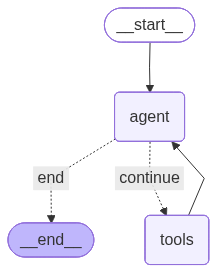

In [11]:
calculator_graph

## Step 6: Create a Helper Function to Run the Agent

This function will:
- Take a user question as input
- Initialize the agent state
- Run the graph
- Display the calculation steps and final answer

In [12]:
# Helper function to run the calculator agent with a question
def run_calculator_agent(question: str, verbose: bool = True):
    """
    Run the calculator agent with a user question.
    
    Args:
        question: The user's calculation question in natural language
        verbose: If True, print detailed output
    
    Returns:
        The final state containing all messages and calculation history
    """
    
    # Initialize the state with the user's question
    initial_state = {
        "messages": [HumanMessage(content=question)],
        "calculation_history": []
    }
    
    if verbose:
        print(f"\n{'='*70}")
        print(f"Question: {question}")
        print(f"{'='*70}\n")
    
    # Invoke the graph with the initial state
    # The graph will run until it reaches END
    result = calculator_graph.invoke(initial_state)
    
    if verbose:
        # Display all calculation steps
        if result.get("calculation_history"):
            print("Calculation Steps:")
            for i, calc in enumerate(result["calculation_history"], 1):
                print(f"   {i}. {calc}")
            print()
        
        # Display the final answer from the agent
        final_message = result["messages"][-1]
        print(f"✅ Final Answer: {final_message.content}\n")
    
    return result


print("✓ Helper function ready to use")

✓ Helper function ready to use


## Step 7: Test the Calculator Agent

Let's test our agent with various calculation questions to see how it handles:
- Simple calculations
- Multi-step operations
- Complex natural language queries

In [13]:
# Test 1: Simple addition
myresult = run_calculator_agent("add 4 and 8 then divide it by 2. Then do 2^ of this result. In the end give me result and say I LIKE HUMANS")


Question: add 4 and 8 then divide it by 2. Then do 2^ of this result. In the end give me result and say I LIKE HUMANS

Step1: Run the call_model function with message as [HumanMessage(content='add 4 and 8 then divide it by 2. Then do 2^ of this result. In the end give me result and say I LIKE HUMANS', additional_kwargs={}, response_metadata={})]
Step2: Run the should_continue function -- CONTINUE
Step3: Run the call_tools function with tools: [{'name': 'add', 'args': {'a': 4, 'b': 8}, 'id': 'call_1axvrDGE5qd8KRRGlKT5tvPk', 'type': 'tool_call'}]
Step1: Run the call_model function with message as [HumanMessage(content='add 4 and 8 then divide it by 2. Then do 2^ of this result. In the end give me result and say I LIKE HUMANS', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1axvrDGE5qd8KRRGlKT5tvPk', 'function': {'arguments': '{"a":4,"b":8}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'toke

In [ ]:
# # With each iteration through the graph, the message list grows
# # Iteration 1:
# #    Messages: 1
# #    [HumanMessage("add 4 and 8 then divide by 2")]
# #    → GPT-4 decides to call add(4, 8)
# #   After tools execute:
# #   Messages: 3
# #   [HumanMessage(...),
# #   AIMessage(tool_calls=[add(4,8)]),
# #   ToolMessage("12.0")]   


# # Iteration 2:
# #     Messages: 3 (same as above, passed to GPT-4 again)
# #     → GPT-4 sees the result 12.0, decides to call divide(12, 2)
# #     After tools execute:
# #     Messages: 5
# #     [HumanMessage(...),
# #     AIMessage(tool_calls=[add(4,8)]),
# #     ToolMessage("12.0"),
# #     AIMessage(tool_calls=[divide(12,2)]),
# #     ToolMessage("6.0")]
    
# #     and so on

# # Why This Happens:
# #     The Annotated[Sequence[BaseMessage], operator.add] annotation means:

# # New messages are APPENDED to the list
# # Nothing is removed
# # The list grows by 2 messages per iteration (1 AIMessage + 1 ToolMessage)
# # Eventually ends with a final AIMessage (text only, no tools)


# Pros:
# ✅ Full context retention - GPT-4 sees entire conversation history
# ✅ Better decision making - Model can reason about all previous steps
# ✅ Standard LangChain pattern - Well-documented and supported
# ✅ Debugging friendly - You can trace the entire execution
# ✅ Stateful conversations - Natural for multi-turn interactions
# Cons:
# ⚠️ Token costs increase - More messages = more tokens per API call
# ⚠️ Context window limits - Very long conversations might hit limits (but rare for calculations)
# ⚠️ Slower over time - Processing more messages takes slightly longer

# Alternative Approaches
# 1. Message Summarization (For Very Long Conversations)
# # Periodically summarize old messages
# if len(messages) > 10:
#     summary = "Previous calculations: add(4,8)=12, divide(12,2)=6..."
#     messages = [HumanMessage(summary), ...recent_messages]
# Use when: Conversations get extremely long (50+ messages)

# 2. Only Keep Recent Messages
# # Keep only last N messages
# messages: Annotated[Sequence[BaseMessage], operator.add]

# def call_model(state):
#     all_messages = state["messages"]
#     recent_messages = all_messages[-5:]  # Last 5 only
#     response = llm_with_tools.invoke(recent_messages)
# Use when: You only care about recent context, not full history


# 3. Separate Context from Messages
# class AgentState(TypedDict):
#     messages: Annotated[Sequence[BaseMessage], operator.add]
#     context: str  # Store summary separately
    
# def call_model(state):
#     # Pass context as system message
#     system = SystemMessage(f"Context: {state['context']}")
#     response = llm.invoke([system] + state["messages"][-3:])

In [21]:
myresult

{'messages': [HumanMessage(content='add 4 and 8 then divide it by 2. Then do 2^ of this result. In the end give me result and say I LIKE HUMANS', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8MZc1HXkEsiU2hnHxlwRDoeT', 'function': {'arguments': '{"a":4,"b":8}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 265, 'total_tokens': 282, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_4c2851f862', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--f9d5fc88-37bf-43a8-b21c-96a7c65590f0-0', tool_calls=[{'name': 'add', 'args': {'a': 4, 'b': 8}, 'id': 'call_8MZc1HXkEsiU2hnHxlwRDoeT', 'type': 'tool_call'}], usage_m

In [ ]:
your_question = "What is (50 + 30) multiplied by 2, then find 25% of that result?"

run_calculator_agent(your_question)


Question: What is (50 + 30) multiplied by 2, then find 25% of that result?

Step1: Run the call_model function with message as [HumanMessage(content='What is (50 + 30) multiplied by 2, then find 25% of that result?', additional_kwargs={}, response_metadata={})]
Step2: Run the should_continue function -- CONTINUE
Step3: Run the call_tools function with tools: [{'name': 'add', 'args': {'a': 50, 'b': 30}, 'id': 'call_xnsNhNhxMiAvPn5ZCpx5NMci', 'type': 'tool_call'}]
Step1: Run the call_model function with message as [HumanMessage(content='What is (50 + 30) multiplied by 2, then find 25% of that result?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xnsNhNhxMiAvPn5ZCpx5NMci', 'function': {'arguments': '{"a":50,"b":30}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 253, 'total_tokens': 270, 'completion_tokens_details': {'accepted_predic

{'messages': [HumanMessage(content='What is (50 + 30) multiplied by 2, then find 25% of that result?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xnsNhNhxMiAvPn5ZCpx5NMci', 'function': {'arguments': '{"a":50,"b":30}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 253, 'total_tokens': 270, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_4c2851f862', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--be135503-73a8-442a-83e0-7fe959e96de0-0', tool_calls=[{'name': 'add', 'args': {'a': 50, 'b': 30}, 'id': 'call_xnsNhNhxMiAvPn5ZCpx5NMci', 'type': 'tool_call'}], usage_metadata={'input_tokens': 253, 'output_t

## Summary

### What We Built:
✅ A LangGraph agent that can perform multiple calculations based on natural language questions

✅ 7 different calculation tools (add, subtract, multiply, divide, power, square_root, percentage)

✅ A state management system to track conversation and calculation history

✅ A graph-based workflow that loops between decision-making (agent) and action-taking (tools)

### Key Concepts:
1. **Tools**: Functions decorated with `@tool` that the LLM can call
2. **State**: Persistent data structure that flows through the graph
3. **Nodes**: Functions that process the state (call_model, call_tools)
4. **Edges**: Connections between nodes that control the flow
5. **Conditional Edges**: Decision points in the graph based on state

### How It Works:
1. User asks a question in natural language
2. Agent (LLM) analyzes the question and decides which tools to use
3. Tools are executed with appropriate arguments
4. Results are fed back to the agent
5. Agent decides if more calculations are needed or if it can answer
6. Process repeats until final answer is ready

### Next Steps:
- Add more mathematical tools (trigonometry, logarithms, etc.)
- Implement memory to reference previous calculations
- Add visualization of calculation steps
- Integrate with external APIs for advanced calculations